In [9]:
import cv2 as cv
img = cv.cvtColor(cv.imread('undistort.png'), cv.COLOR_BGR2RGB)

In [10]:
with open('undistort_calibration.yml') as f:
    import yaml
    calibration = yaml.load(f, Loader=yaml.SafeLoader)

In [11]:
import torch
from omnicalib.undistort import Projection, Undistort

poly_rz = torch.tensor(calibration['poly_radius_to_z'], dtype=torch.float32)
poly_thetar = poly_rz.new_tensor(calibration['poly_incident_angle_to_radius'])
principal_point = poly_rz.new_tensor(calibration['principal_point'])
view_shape = (384, 512)
fovx = torch.deg2rad(poly_rz.new_tensor(35))

projection = Projection(poly_thetar, poly_rz, principal_point)
undistort = Undistort(
    projection,
    view_shape,
    fovx,
    poly_rz.new_tensor(((0, 1, 0), (1, 0, 0)))
)

In [12]:
from omnicalib.undistort import get_view_vectors
view_vectors = get_view_vectors(view_shape, fovx).view(view_shape + (3,))
view_border = torch.cat((
    view_vectors[0],
    view_vectors[:, -1],
    view_vectors[-1, :].flip(0),
    view_vectors[:, 0].flip(0),
    view_vectors[0:1, 0]
))

In [13]:
p_image = poly_rz.new_tensor((
    (1720, 750),
    (1315, 165)
))

M, undistorted = undistort(
    torch.from_numpy(img).permute(2, 0, 1)[None].to(poly_rz),
    p_image
)

view_border = view_border[None] @ M.swapaxes(-2, -1)
img_border = projection.view_to_image(view_border, True)

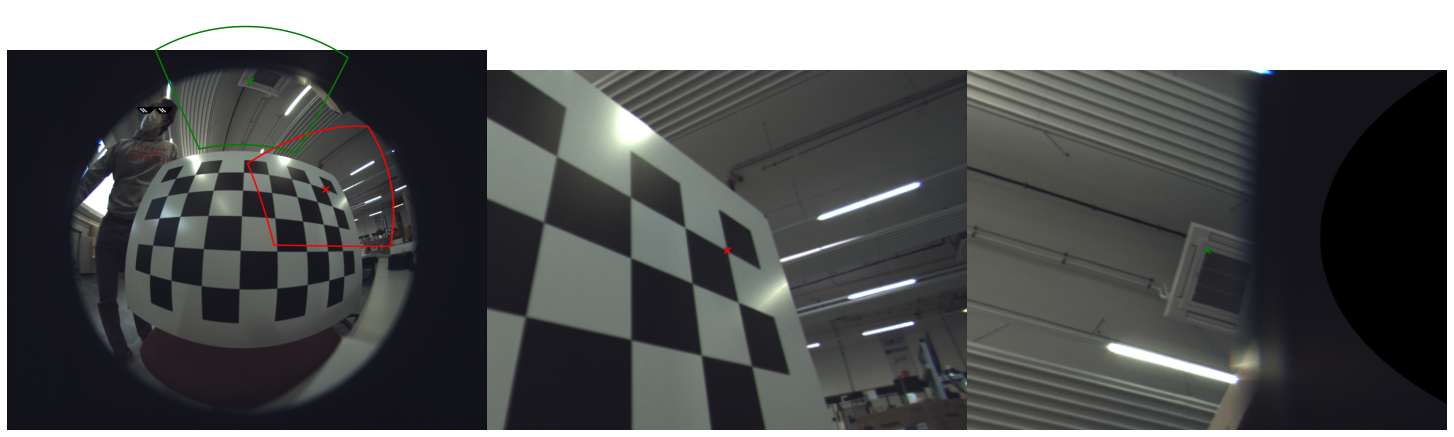

In [14]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
for a in ax:
    a.axis('off')
    a.set_anchor('S')
ax[0].imshow(img)
ax[0].scatter(p_image[:, 0], p_image[:, 1], color=('r', 'g'), marker='x')
for ib, c in zip(img_border, 'rg'):
    ax[0].plot(ib[:, 0], ib[:, 1], color=c)
for idx, (u, c) in enumerate(zip(undistorted, 'rg')):
    ax[idx + 1].imshow((u.permute(1, 2, 0) / 255.).clamp(0, 1))
    ax[idx + 1].scatter(view_shape[1] * 0.5 - 0.5, view_shape[0] * 0.5 - 0.5, color=c, marker='x')
# plt.savefig('banner.png', facecolor='k', transparent=False)
plt.show()